## PortfolioCrossSection_momentum


### Preliminaries

This code builds cross-sectional portfolio strategies and produces relevant analytics.

- We use the data `MasterData_small.parquet`. 

In [1]:
import qpm_download
import qpm
import pandas as pd
import numpy as np
import wrds
import statsmodels.api as sm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

We now choose whether to import data directly from WRDS (`import_data` = True) or to load data from dropbox (`import_data` = False). If you choose to load data from dropbox, make sure to define the data directoy (`_DATA_DIR`). Also, define a directory where you'd like to store the strategy returns (`_STRATEGY_DIR`). In future versions, we'll use a much larger data set, named `MasterData.parquet` (it is already in dropbox), but the core strategies will be constructed using `MasterData_small.parquet`. 

In [2]:
import_data = False             # <-- Edit this line
_DATA_DIR = '/Users/jiahongcai/Desktop/Quantitative Strategies/Data'           # <-- Edit this line
_STRATEGY_DIR = '/Users/jiahongcai/Desktop/Quantitative Strategies/Strategies/Return'   # <-- Edit this line

Next, we specify the strategy settings.
- First, we select the strategy name. At this point, we have `Value` and `Size`. We'll add more later.
- We can sort every month (`Monthly`) or only in June (`June`). As accounting data mostly comes out quarterly or annually, sorting once a year is often sufficient. As most companies have their fiscal year end in December, and we wait six months to make sure the data are available to investors, we sort in June.
- We can set `_REMOVE_MICRO_CAPS` to either `False` or `True`. If `True`, then we drop the smallest stocks. 
- The next two lines select the sample. 
- The final line selects the number of portfolios. We typically set this to 5 or 10.

In [3]:
_STRATEGY_NAME = 'Momentum'      
_SORT_FREQUENCY = 'Monthly'        # Either "Monthly" or "June"

_REMOVE_MICRO_CAPS = False      # Either "True" or "False"
_SAMPLE_START = '2001-01-01'
_SAMPLE_END = '2023-07-31'
_NUM_PORT = 5

### Step 1. Construct Signal

Let's first see which variables are available in the data (running the next block requires you to download 'MasterData.parquet'. You can skip this line if you havem't done so):

In [4]:
qpm.list_variables(data_dir = _DATA_DIR, file_name = 'MasterData.parquet')

Identifiers:
['permno', 'ticker', 'comnam', 'gvkey', 'conm', 'cusip', 'lpermco']

Prices and Returns:
['ret', 'retx', 'prc', 'prcc_c', 'prcc_f', 'vwretd', 'ewretd']

Fama-French:
['mktrf', 'smb', 'hml', 'rf', 'umd', 'rmw', 'cma']

Fundamentals:
['aco', 'act', 'ajex', 'am', 'ao', 'ap', 'at', 'capx', 'che', 'cogs', 'csho', 'cshrc', 'dcpstk', 'dcvt', 'dlc', 'dlcch', 'dltis', 'dltr', 'dltt', 'dm', 'dp', 'drc', 'drlt', 'dv', 'dvc', 'dvp', 'dvpa', 'dvpd', 'dvpsx_c', 'dvt', 'ebit', 'ebitda', 'emp', 'epspi', 'epspx', 'fatb', 'fatl', 'ffo', 'fincf', 'fopt', 'gdwl', 'gdwlia', 'gdwlip', 'gwo', 'ib', 'ibcom', 'intan', 'invt', 'ivao', 'ivncf', 'ivst', 'lco', 'lct', 'lo', 'lt', 'mib', 'msa', 'ni', 'nopi', 'oancf', 'ob', 'oiadp', 'oibdp', 'pi', 'ppenb', 'ppegt', 'ppenls', 'ppent', 'prstkc', 'prstkcc', 'pstk', 'pstkl', 'pstkrv', 're', 'rect', 'recta', 'revt', 'sale', 'scstkc', 'seq', 'spi', 'sstk', 'tstkp', 'txdb', 'txdi', 'txditc', 'txfo', 'txfed', 'txp', 'txt', 'wcap', 'wcapch', 'xacc', 'xad', 'xint

We will work initially with a smaller data set `MasterData_small.parquet`, which is less demanding in terms of your computer's memory.

In [5]:
qpm.list_variables(data_dir = _DATA_DIR, file_name = 'MasterData_small.parquet')

Identifiers:
['permno', 'ticker', 'comnam', 'conm']

Prices and Returns:
['ret', 'retx', 'prc', 'vwretd']

Fama-French:
['mktrf', 'smb', 'hml', 'rf', 'umd', 'rmw', 'cma']

Fundamentals:
['at', 'cogs', 'revt', 'be']

Others:
['vol', 'me', 'ESG_score', 'E_score', 'S_score', 'G_score', 'carbon_intensity']



#### Load Data

Startegies differ by the signals that they use, and the signals use differ input data. Thus, we first construct the list of fundamentals that we need to load given the strategy that we specified in `_STRATEGY_NAME`. If you change the strategy, then you can change the list of variables you need here.

In [6]:
signal_variables = qpm.return_signal(_STRATEGY_NAME)
signal_variables

[]

Given the list of fundamentals needed to construct the strategy in `_STRATEGY_NAME`, which is in `signal_variables`, we proceed by loading the relevant data.

In [7]:
if import_data == True:

    df_full = qpm_download.cross_section_compact(_SAMPLE_START, _SAMPLE_END, _STRATEGY_NAME, signal_variables)
    
if import_data == False:
    
    df_full = qpm.load_data(data_dir = _DATA_DIR, file_name = 'MasterData_small.parquet', variable_list = signal_variables)


> Loading Raw Data...
> Renaming key variables...
> Dropping duplicates...
> Creating Auxiliary Variables...


#### Plot Key Variables

We first list the columns in our data

In [8]:
df_full.columns

Index(['permno', 'ret', 'retx', 'vol', 'shrout', 'prc', 'shrcd', 'exchcd',
       'ticker', 'comnam', 'ldate', 'mve_c', 'conm', 'at', 'cogs', 'revt',
       'mktrf', 'smb', 'hml', 'rf', 'umd', 'rmw', 'cma', 'vwretd', 'beta',
       'me', 'daret', 'be', 'profitA', 'ESG_score', 'E_score', 'S_score',
       'G_score', 'carbon_intensity', 'ldate_lag', 'screen', 'ldate_lag12',
       'screen12', 'me_lagged'],
      dtype='object')

Next, we plot a variable of interest, such as in this case a stock's market capitalization.

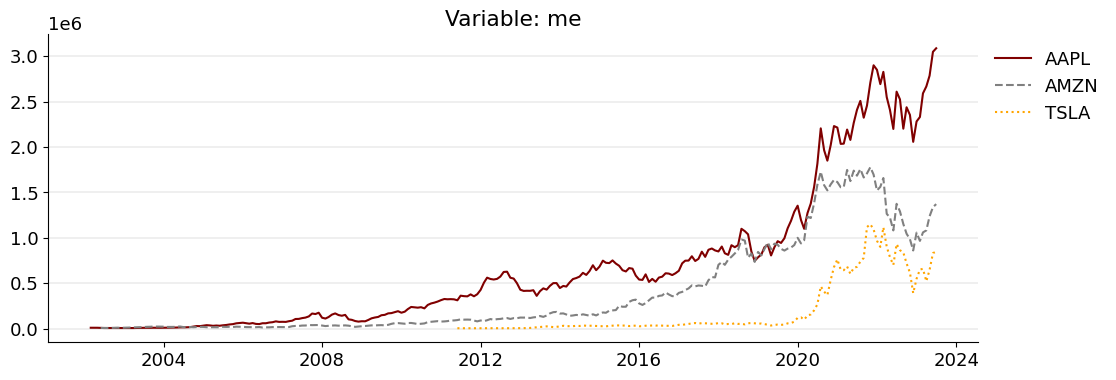

In [9]:
qpm.plot_variables(df_full, variable_list = ['me'],  id_type = 'ticker', id_list = ['AAPL', 'AMZN', 'TSLA'],
                     start_date = '1999-01-01', end_date = '2023-07-31')

#### Construct Signal

In [10]:
if _STRATEGY_NAME == 'Size':

	df_full['signal'] = - df_full['me']
	
elif _STRATEGY_NAME == 'Value':

	df_full['signal'] = df_full['be'] / df_full['me']	
		
elif _STRATEGY_NAME == 'AssetGrowth':

	df_full['signal'] = -df_full['at'] / qpm.create_lag(df_full, var_name = 'at', lag = 12)	

elif _STRATEGY_NAME == 'Quality':

	# Signal 1 : Rank low beta
	df_full['beta_inv'] = -df_full['beta']
	df_full['signal_1'] = qpm.rank(df_full, var_name = 'beta_inv')

	# Signal 2 : Rank profitability
	df_full['profitability'] = (df_full['revt'] - df_full['cogs']) / df_full['at']
	df_full['signal_2'] = qpm.rank(df_full, var_name = 'profitability')

	# Final Signal
	df_full['signal'] = (df_full['signal_1'] + df_full['signal_2']) / 2

elif _STRATEGY_NAME == 'Momentum':

	# Sort data
	df_full.sort_values(['permno', 'ldate'], ascending = [True, True], inplace = True)      

	# Check that we have 12 observations for a stock
	df_full['ldate12'] = df_full[['ldate','permno']].groupby('permno')['ldate'].shift(12)
	df_full['signal'] = (df_full['ldate'] == df_full['ldate12'] + pd.DateOffset(months = 12)).map(lambda x : 0 if x else np.nan)

	# In month t, add the returns from t-1, t-2, ..., t-12. Hence, we skip one month
	for i in range(1, 11 + 1):
		# Create a variable for each lag of the returns
		df_full['daret%d' %(i)] = df_full[['daret', 'permno']].groupby('permno')['daret'].shift(i)
		
		# Sum the returns over the last year
		df_full['signal'] += df_full['daret%d' %(i)].notnull() * np.log(1 + df_full['daret%d' %(i)]).fillna(0.0)
		
		# Drop the variable that we created in the previous step
		df_full.drop(columns = ['daret%d' %(i)], inplace = True)    
        
else:
	
	raise Exception('Please provide a valid _STRATEGY_NAME..')  
    
df_sum = df_full.sort_values(['ldate','ticker'])	
print(df_sum[['ldate','ticker','me','signal','daret']].loc[df_sum['ticker'].isin(['AAPL', 'AMZN', 'TSLA'])].tail(3))    

             ldate ticker            me    signal     daret
121071  2023-07-01   AAPL  3.089904e+06  0.182891  0.012785
691699  2023-07-01   AMZN  1.371604e+06 -0.034605  0.025468
1074188 2023-07-01   TSLA  8.488228e+05 -0.126771  0.021622


#### Sample Selection

We lag the signal by one month and select the relevant sample (i.e., the sample period and whether we include micro caps or not).

In [11]:
# Lag signal by one period so that the signal value is known at the time of portfolio creation
df_full['signal'] = qpm.create_lag(df_full, var_name = 'signal', lag = 1)

# Select the relevant sample
df = qpm.select_sample(df_full, sample_start = _SAMPLE_START, sample_end = _SAMPLE_END, remove_micro_caps = _REMOVE_MICRO_CAPS)

> Selecting Sample for Given Criteria...


### Step 2. Portfolio Construction

Next, we sort the stocks into portfolios:
- retP_rank_longonly: Rank-based long-only portfolio
- retP_rank_longshort: Rank-based long-short portfolio
- retP_vw_P1, ..., retP_vw_P5: The returns on the 5 portfolios sorted by the signal (value or size) and weighted by market capitalization
- retF_vw: The return on the factor, which is retP_vw_P5-retP_vw_P1

In [12]:
df, df_rets = qpm.create_portfolios(df, sort_frequency = _SORT_FREQUENCY, num_port = _NUM_PORT)
print(df_rets.tail())

> Sorting stocks into 5 portfolios at frequency: Monthly...
> Computing returns using various weights...
         ldate  retP_rank_longonly  retP_rank_longshort  retP_vw_P1  \
247 2023-03-01           -0.042893             0.068096    0.055565   
248 2023-04-01           -0.016509             0.018584   -0.034678   
249 2023-05-01           -0.008349            -0.006689    0.051329   
250 2023-06-01            0.069229             0.014974    0.123600   
251 2023-07-01            0.043949            -0.043886    0.077448   

     retP_vw_P2  retP_vw_P3  retP_vw_P4  retP_vw_P5   retF_vw  
247    0.048458    0.010969    0.012407    0.002346 -0.053219  
248    0.020652    0.007757    0.015232    0.013270  0.047948  
249   -0.005039    0.002551   -0.008959    0.019218 -0.032111  
250    0.069315    0.051460    0.068779    0.078752 -0.044848  
251    0.048449    0.041259    0.031455    0.024760 -0.052688  


### Step 3. Portfolio Analytics

We first plot the average returns on the portfolios. Then, we plot the cumulative returns on various strategies. For the long-only strategy, we use the market as a simple benchmark. For the long-short strategies, we use the risk-free rate as a benchmark. Later, we will use regression analysis to properly correct for the factors.

> Merging strategy returns with Fama and French factor returns...


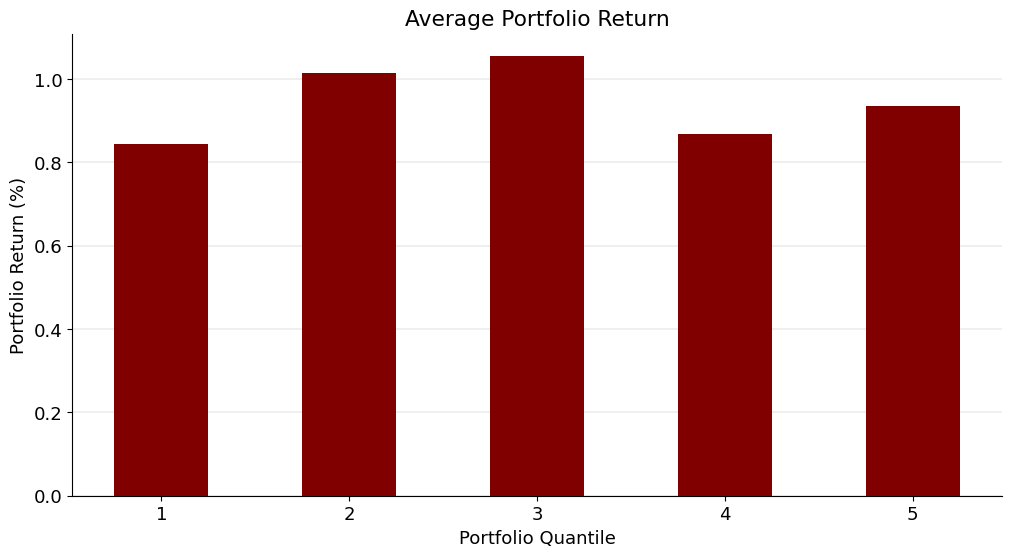

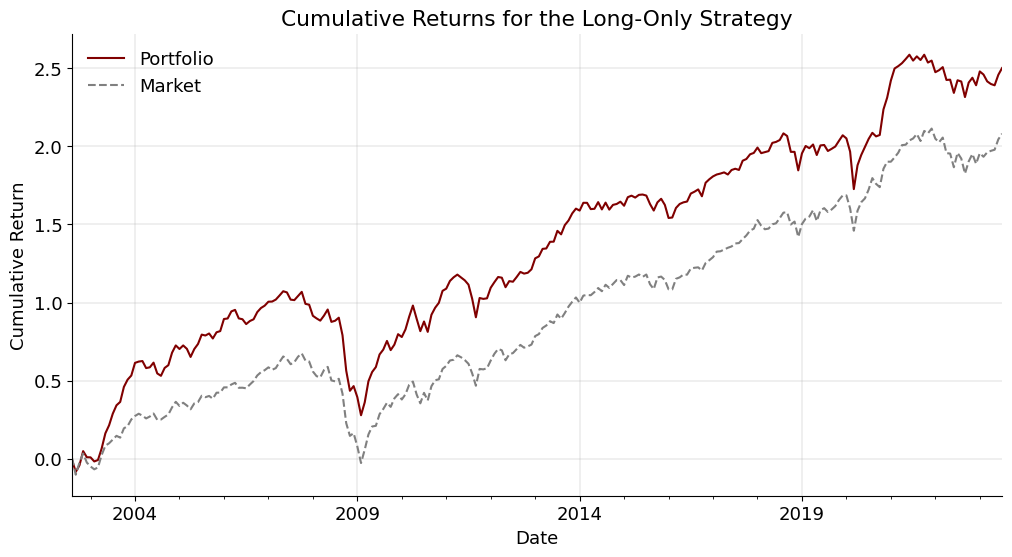

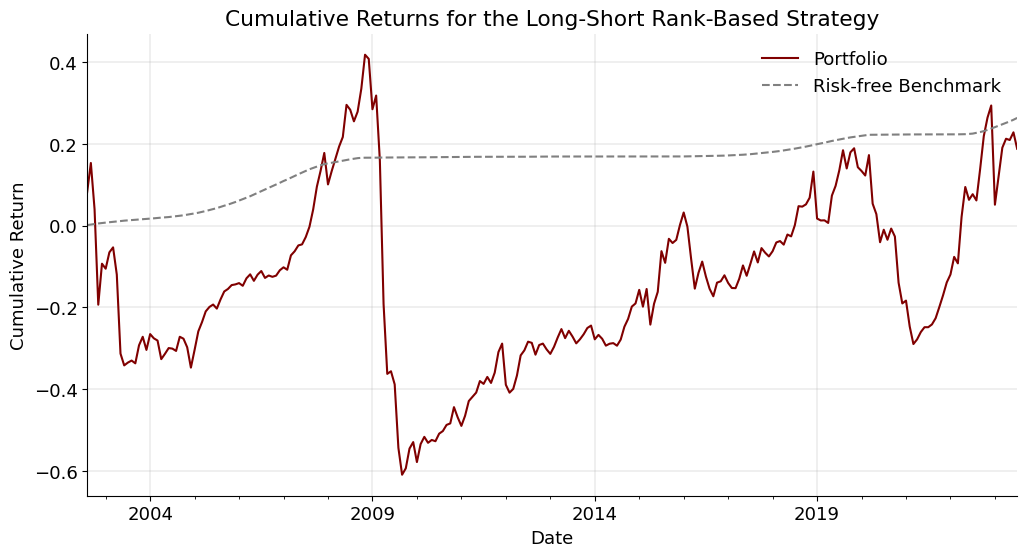

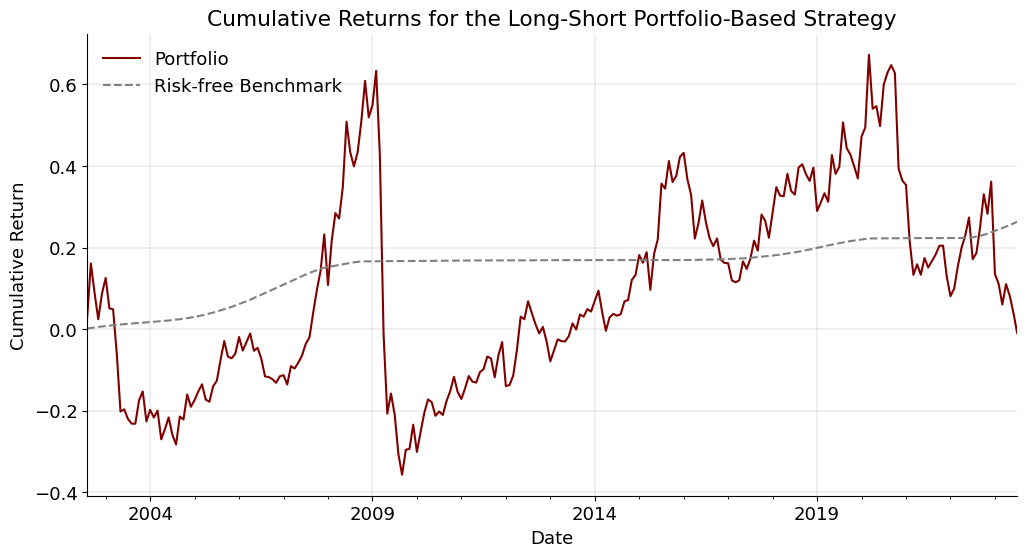

In [13]:
qpm.analyze_strategy(df_rets, analysis_type = 'Performance')

In [14]:
qpm.analyze_strategy(df_rets, analysis_type = 'Summary')

> Merging strategy returns with Fama and French factor returns...
                     count      mean       std       min       25%       50%  \
retP_rank_longonly   252.0  0.011428  0.053831 -0.212974 -0.015586  0.013326   
retP_rank_longshort  252.0  0.001050  0.050005 -0.296034 -0.013575  0.008153   
retF_vw              252.0  0.000918  0.061605 -0.354758 -0.029497  0.005293   
mktrf                252.0  0.008233  0.044525 -0.172300 -0.016000  0.013200   
smb                  252.0  0.001356  0.025572 -0.082800 -0.015075  0.001550   
hml                  252.0 -0.000471  0.031147 -0.138700 -0.017050 -0.002000   

                          75%       max  
retP_rank_longonly   0.043654  0.177453  
retP_rank_longshort  0.027978  0.120165  
retF_vw              0.033871  0.194445  
mktrf                0.033475  0.136500  
smb                  0.018275  0.071300  
hml                  0.014725  0.127500  


In [15]:
qpm.analyze_strategy(df_rets, analysis_type = 'Factor Regression')

> Merging strategy returns with Fama and French factor returns...

---------------------------------------------------------------
> Running Factor Regressions: Table 1  - 3 Fama-French Factors
---------------------------------------------------------------

                  (1)        (2)       (3)        (4)        (5)       (6)    
------------------------------------------------------------------------------
const          0.0059*    0.0012    0.0047     0.0053     0.0016**  0.0046    
               (0.0036)   (0.0014)  (0.0030)   (0.0034)   (0.0007)  (0.0029)  
mktrf          -0.6092*** 1.1105*** -0.4400*** -0.5415*** 0.9480*** -0.3706***
               (0.0786)   (0.0306)  (0.0654)   (0.0805)   (0.0157)  (0.0691)  
hml                                            -0.5130*** 0.0540**  0.0048    
                                               (0.1125)   (0.0219)  (0.0965)  
smb                                            -0.0969    0.7720*** -0.3428***
                              

In [16]:
if _REMOVE_MICRO_CAPS:
    save_dir = '%s/StrategyReturns_%s_%s_noMicroCaps.csv' %(_STRATEGY_DIR, _STRATEGY_NAME, _SORT_FREQUENCY)
else:
    save_dir = '%s/StrategyReturns_%s_%s_withMicroCaps.csv' %(_STRATEGY_DIR, _STRATEGY_NAME, _SORT_FREQUENCY)

df_rets.to_csv(save_dir)
print('Saved Strategy Returns to %s' %(save_dir))

Saved Strategy Returns to /Users/jiahongcai/Desktop/Quantitative Strategies/Strategies/Return/StrategyReturns_Momentum_Monthly_withMicroCaps.csv
